In [1]:
import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

import pandas as pd
import numpy as np
import time

from raptcr.constants.datasets import sample_tcrs
from raptcr.constants.sampling import match_vj_distribution
from raptcr.hashing import TCRDistEncoder
from raptcr.indexing import IvfIndex, FlatIndex
from raptcr.neighbors import index_neighbors

### Foreground repertoire

In [2]:
size = 100000
fg = sample_tcrs(size)
fg.head()

,junction_aa,v_call,j_call
0,CATSFPPQGREYF,TRBV15*01,TRBJ2-7*01
1,CASRTPPGTRKANEQYF,TRBV6-6*01,TRBJ2-7*01
2,CASSFSGRSSYEQYF,TRBV12-3*01,TRBJ2-7*01
3,CATMDQLKRLTSYEQYF,TRBV24-1*01,TRBJ2-7*01
4,CASSQGQSGANVLTF,TRBV14*01,TRBJ2-6*01


In [3]:
encoder = TCRDistEncoder(aa_dim=8, full_tcr=True).fit()

#### **IVF INDEX**

In [4]:
t0 = time.time()
fg_index_ivf = IvfIndex(hasher=encoder, n_centroids=500, n_probe=50)
fg_index_ivf.add(fg)
t1 = time.time() - t0
print(f'building index: {t1}')

t0 = time.time()
ivf_neighbors = index_neighbors(fg, index=fg_index_ivf, r=12.5)
t2 = time.time() - t0
print(f'retrieving neighbors: {t2}')
print(f'total runtime: {t1+t2}')

building index: 7.553926706314087
retrieving neighbors: 34.151526927948
total runtime: 41.705453634262085


#### **FLAT INDEX**

In [5]:
t0 = time.time()
fg_index_flat = FlatIndex(hasher=encoder)
fg_index_flat.add(fg)
t1 = time.time() - t0
print(f'building index: {t1}')

t0 = time.time()
flat_neighbors = index_neighbors(fg, index=fg_index_flat, r=12.5)
t2 = time.time() - t0
print(f'retrieving neighbors: {t2}')
print(f'total runtime: {t1+t2}')

building index: 6.0676045417785645
retrieving neighbors: 37.25547742843628
total runtime: 43.323081970214844


In [183]:
from scipy.stats import hypergeom

def tcr_dict_to_df(neighbor_counts, cutoff=1, add_counts=False):
    neighbor_counts = {i:neighbor_counts[i] for i in neighbor_counts if neighbor_counts[i] > cutoff}
    vgenes = [i.split('_')[0] for i in list(neighbor_counts.keys())]
    cdr3aa = [i.split('_')[1] for i in list(neighbor_counts.keys())]
    if not add_counts:
        return pd.DataFrame({'v_call':vgenes, 'junction_aa':cdr3aa})
    else:
        counts = list(neighbor_counts.values())
        return pd.DataFrame({'v_call':vgenes, 'junction_aa':cdr3aa, 'neighbors':counts})

def calculate_pvalues(repertoire, prefilter=True, depth=1000001):

    encoder = TCRDistEncoder(aa_dim=8, full_tcr=True).fit()
    print('Retrieving foreground neighbors')
    fg_index = FlatIndex(hasher=encoder)
    fg_index.add(repertoire)
    nbr_counts = index_neighbors(query=repertoire, index=fg_index, r=12.5)

    print('retrieving background neighbors')
    bg_index = IvfIndex(hasher=encoder, n_centroids=1000, n_probe=5)
    if prefilter:
        print('prefiltering')
        n_bg = len(repertoire)
        bg = match_vj_distribution(n=n_bg, foreground=fg)
        bg_index.add(bg)
        del bg
        seq_with_nbrs = tcr_dict_to_df(nbr_counts, add_counts=True)
        nbrs_in_background = index_neighbors(query=seq_with_nbrs, index=bg_index, r=12.5)
        nbrs_in_background = tcr_dict_to_df(nbrs_in_background, add_counts=True)

        merged = seq_with_nbrs.merge(nbrs_in_background, on=['v_call', 'junction_aa'])
        filtered = merged[merged['neighbors_x']>merged['neighbors_y']]
        filtered = filtered.drop(columns=['neighbors_y']).rename(columns={'neighbors_x':'neighbors'})
        bg_index.n_probe = 10
        print('finished prefiltering')
    bg = match_vj_distribution(n=depth, foreground=fg)
    bg_index.add(bg)
    del bg

    nbrs_in_background = index_neighbors(query=filtered, index=bg_index, r=12.5)
    nbrs_in_background = tcr_dict_to_df(nbrs_in_background, add_counts=True)

    merged = filtered.merge(nbrs_in_background, on=['v_call', 'junction_aa'])
    M = len(bg_index.ids) + len(repertoire)
    N = len(repertoire)
    print('testing')
    merged['pval'] = merged.apply(
        lambda x: hypergeom.sf(x['neighbors_x']-1, M, x['neighbors_x'] + x['neighbors_y'], N),
        axis=1
        )
    return merged.sort_values(by='pval')

In [184]:
encoder = TCRDistEncoder(aa_dim=8, full_tcr=True).fit()
size = 100000

for i in range(1,21):
    print(i)

    fg = sample_tcrs(size)
    p = calculate_pvalues(fg)

    p['iteration'] = i
    p.to_csv('./data/res/fdr_testing_100k.tsv', mode='a', sep='\t', index=False, header=False)

11
Retrieving foreground neighbors
retrieving background neighbors
prefiltering
finished prefiltering
testing
12
Retrieving foreground neighbors
retrieving background neighbors
prefiltering
finished prefiltering
testing
13
Retrieving foreground neighbors
retrieving background neighbors
prefiltering
finished prefiltering
testing
14
Retrieving foreground neighbors
retrieving background neighbors
prefiltering
finished prefiltering
testing
15
Retrieving foreground neighbors
retrieving background neighbors
prefiltering
finished prefiltering
testing
16
Retrieving foreground neighbors
retrieving background neighbors
prefiltering
finished prefiltering
testing
17
Retrieving foreground neighbors
retrieving background neighbors
prefiltering
finished prefiltering
testing
18
Retrieving foreground neighbors
retrieving background neighbors
prefiltering
finished prefiltering
testing
19
Retrieving foreground neighbors
retrieving background neighbors
prefiltering
finished prefiltering
testing
20
Retriev

In [186]:
df = pd.read_csv('./data/res/fdr_testing_100k.tsv', sep='\t')
df['expected_neighbors'] = (df.neighbors_y/1100000)*100000
df['fold_change'] = df.neighbors_x / df.expected_neighbors
df['neg_log_pvalue'] = -np.log10(df.pval)

In [204]:
thresholds = [10**(-i) for i in range(7)]

final = []
for t in thresholds:
    res = pd.DataFrame(df[df.pval<t].iteration.value_counts().sort_index()/df.iteration.value_counts().sort_index())
    res['n_hits'] = df[df.pval<t].iteration.value_counts().sort_index()
    res['threshold'] = t
    final.append(res)

final = pd.concat(final)
final

,iteration,n_hits,threshold
0,1.000000,1865,1.000000
1,1.000000,1839,1.000000
2,1.000000,1885,1.000000
3,1.000000,2049,1.000000
4,1.000000,1800,1.000000
...,...,...,...
16,0.006978,13,0.000001
17,0.018038,32,0.000001
18,0.005882,11,0.000001
19,0.012088,22,0.000001


In [201]:
final.groupby('threshold').iteration.mean()

threshold
0.000001    0.008678
0.000010    0.019140
0.000100    0.040629
0.001000    0.094069
0.010000    0.243382
0.100000    0.658796
1.000000    1.000000
Name: iteration, dtype: float64

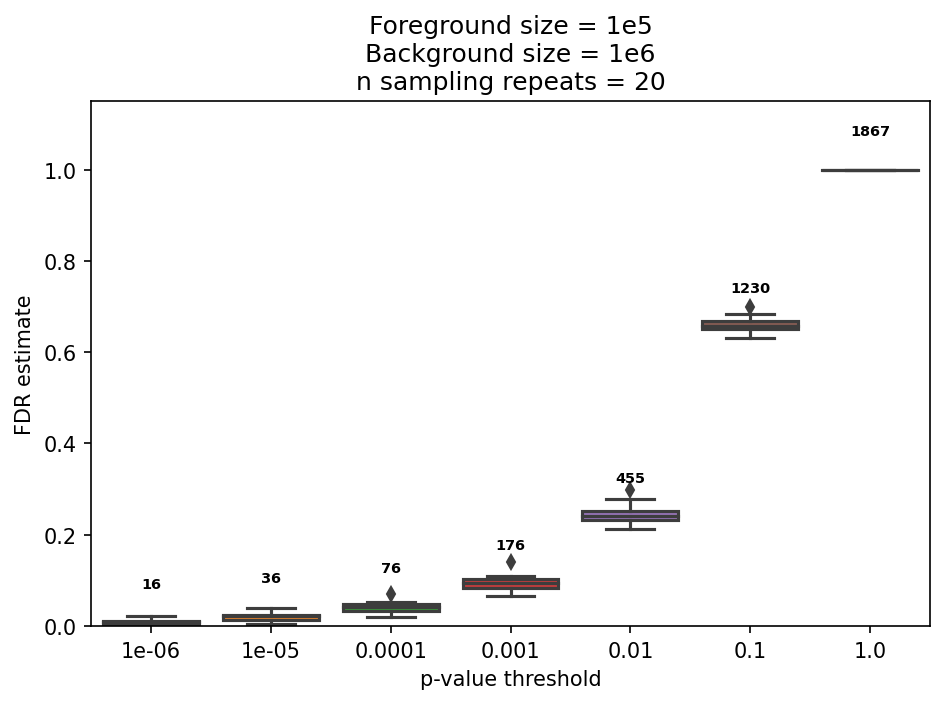

In [202]:
import seaborn as sns

fig, ax = plt.subplots(dpi=150)

box_plot = sns.boxplot(
    x='threshold',
    y='iteration',
    data=final
)

box_plot.get_xticks()
nhits = final.groupby('threshold').n_hits.sum()
nhits = np.round(nhits / 21,0).astype(int)
# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,nhits[xtick], nhits[xtick], 
#             horizontalalignment='center',size='x-small',color='w',)

x = final.groupby('threshold').iteration.median()

for n,i in enumerate(x.values):
    box_plot.text(n,i+.075,nhits.iloc[n], weight='semibold', horizontalalignment='center',size='x-small')

ax.set_ylim(0,1.15)
ax.set_ylabel('FDR estimate')
ax.set_xlabel('p-value threshold')
ax.set_title('Foreground size = 1e5\nBackground size = 1e6\nn sampling repeats = 20')
fig.tight_layout()

In [178]:
df.neighbors_y * 100000 / 1100000


0         5.181818
1         7.090909
2         7.090909
3        11.272727
4         4.909091
           ...    
20906     4.909091
20907     4.909091
20908     6.454545
20909     8.272727
20910     7.000000
Name: neighbors_y, Length: 20911, dtype: float64

### Don't mind the rest of this notebook
### vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

In [1]:
import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')
from raptcr.constants.sampling import match_vj_distribution, get_vfam
from raptcr.constants.datasets import example_tcr, sample_tcrs

In [2]:
bg = match_vj_distribution(n=int(1.5e6), foreground=example_tcr)

In [4]:
bg.dropna()

,v_call,j_call,junction_aa
0,TRBV5-6*01,TRBJ2-2*01,CASSEELSATGELFF
1,TRBV5-1*01,TRBJ2-7*01,CASSAEGRYEQYF
2,TRBV5-1*01,TRBJ2-3*01,CASSESRDMRTSGGAQADTQYF
3,TRBV5-6*01,TRBJ2-1*01,CASSENRARDEQFF
4,TRBV5-6*01,TRBJ2-6*01,CASSVTGKSSGANVLTF
...,...,...,...
1499995,TRBV3-1*01,TRBJ1-1*01,CASSPRCPVNTEAFF
1499996,TRBV3-1*01,TRBJ1-6*01,CSANLIRDRYNSPLHF
1499997,TRBV3-1*01,TRBJ1-2*01,CASSSPGSGQGGGAGYGYTF
1499998,TRBV3-1*01,TRBJ1-6*01,CASSQAGCQVLENSPLHF


In [1]:
import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

from raptcr.neighbors import NeighborEnrichment
from raptcr.hashing import TCRDistEncoder
from raptcr.constants.datasets import example_tcr

In [2]:
test = example_tcr[:50000]
test

,v_call,j_call,junction_aa
0,TRBV5-5*01,TRBJ1-1*01,CASSSGQGVESTEAFF
1,TRBV5-5*01,TRBJ2-4*01,CASSLYTGIAKNIQYF
2,TRBV5-5*01,TRBJ1-3*01,CASSLSGAGNTIYF
3,TRBV5-5*01,TRBJ2-1*01,CASSLLAGPYNEQFF
4,TRBV5-5*01,TRBJ2-1*01,CASSLGLTGRYNEQFF
...,...,...,...
49995,TRBV19*01,TRBJ2-1*01,CASSIVGTSGYNEQFF
49996,TRBV19*01,TRBJ2-4*01,CASSIVVLGQGGNIQYF
49997,TRBV27*01,TRBJ2-7*01,CASSWIPSYEQYF
49998,TRBV27*01,TRBJ2-7*01,CASTGTSGYEQYF


In [3]:
hasher = TCRDistEncoder(aa_dim=8, full_tcr=True)

ne = NeighborEnrichment(
    repertoire = test,
    hasher=hasher,
    radius=12.5
)

ne.compute_neighbors(exhaustive=True)
p = ne.compute_pvalues()



retrieving background neighbors
prefiltering


/home/sebastiaan/PhD/Repositories/immune_response_detection/raptcr/constants/sampling.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foreground['vfam'] = get_vfam(foreground)
/home/sebastiaan/PhD/Repositories/immune_response_detection/raptcr/constants/sampling.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foreground['jfam'] = get_jfam(foreground)


finished prefiltering


/home/sebastiaan/PhD/Repositories/immune_response_detection/raptcr/constants/sampling.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foreground['vfam'] = get_vfam(foreground)
/home/sebastiaan/PhD/Repositories/immune_response_detection/raptcr/constants/sampling.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foreground['jfam'] = get_jfam(foreground)


testing


In [19]:
import pandas as pd
from raptcr.neighbors import tcr_dict_to_df

thr = p[p.pval<1e-5]
thr[thr.v_call!='TRBV20-1*01']

q = pd.DataFrame(p.loc[1846]).T
print(q)
tcr_dict_to_df(dict(ne.fg_index.radius_search(q, r=12.5)), add_counts=True)

           v_call    junction_aa foreground_neighbors background_neighbors  \
1846  TRBV11-3*01  CASSLKGNTEAFF                   26                    6   

     pval  
1846  0.0  


,v_call,junction_aa,neighbors
0,TRBV11-3*01,CASSLTVNTEAFF,11.730832
1,TRBV11-3*01,CASSLKPNTEAFF,8.384821
2,TRBV11-3*01,CASSLGRNTEAFF,11.151169
3,TRBV11-3*01,CASSLTSNTEAFF,11.349998
4,TRBV11-3*01,CASSRGGNTEAFF,10.597225
5,TRBV11-3*01,CASSVGGNTEAFF,9.762843
6,TRBV11-3*01,CASSLGGDTEAFF,9.479510
7,TRBV11-3*01,CASSLSENTEAFF,10.817318
8,TRBV11-3*01,CASSYQGNTEAFF,9.014727
9,TRBV11-3*01,CASSDTGNTEAFF,12.343079


In [56]:
X = ne.hasher.transform(p)
p['X'] = list(X)
p

,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,X
870,TRBV20-1*01,CSARVNTEAFF,52,15,2.660473e-56,"[0.35754014895630654, 0.6192218357375268, 0.07..."
365,TRBV20-1*01,CSARKNTEAFF,46,13,3.894776e-50,"[0.35754014895630654, 0.6192218357375268, 0.07..."
595,TRBV20-1*01,CSAKGNTEAFF,46,20,2.846520e-46,"[0.35754014895630654, 0.6192218357375268, 0.07..."
378,TRBV20-1*01,CSARGGTEAFF,47,23,4.967705e-46,"[0.35754014895630654, 0.6192218357375268, 0.07..."
627,TRBV20-1*01,CSARENTEAFF,42,14,1.256152e-44,"[0.35754014895630654, 0.6192218357375268, 0.07..."
...,...,...,...,...,...,...
1556,TRBV27*01,CASKGVYEQYF,5,128,7.272678e-01,"[-0.02197329555010122, -0.31324576752172145, -..."
1541,TRBV2*01,CASIRTYEQYF,6,153,7.335755e-01,"[0.10839431160887886, -0.3670802856233772, 0.4..."
441,TRBV27*01,CATGRFYEQYF,6,160,7.698845e-01,"[-0.02197329555010122, -0.31324576752172145, -..."
1308,TRBV7-9*01,CASRGSAYEQYF,3,91,8.058981e-01,"[0.10839431160887886, -0.3670802856233772, 0.4..."


In [62]:
res1 = ne.fg_index.idx.range_search(np.expand_dims(p['X'].iloc[0].astype(np.float32), axis=0), thresh=12.5)
res2 = ne.fg_index.idx.range_search(X.astype(np.float32), thresh=12.5)

In [85]:
import itertools

a, b = itertools.tee(res2[0])
next(b,None)
borders = list(zip(a, b))

p['neighbor_ids'] = [res2[2][i[0]:i[1]] for i in borders]
p

,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,X,neighbor_ids
870,TRBV20-1*01,CSARVNTEAFF,52,15,2.660473e-56,"[0.35754014895630654, 0.6192218357375268, 0.07...","[1486, 1622, 1706, 2512, 2516, 2915, 2922, 319..."
365,TRBV20-1*01,CSARKNTEAFF,46,13,3.894776e-50,"[0.35754014895630654, 0.6192218357375268, 0.07...","[1481, 1486, 2125, 2516, 2915, 4188, 4508, 484..."
595,TRBV20-1*01,CSAKGNTEAFF,46,20,2.846520e-46,"[0.35754014895630654, 0.6192218357375268, 0.07...","[1481, 1486, 1487, 2516, 2915, 4188, 5341, 534..."
378,TRBV20-1*01,CSARGGTEAFF,47,23,4.967705e-46,"[0.35754014895630654, 0.6192218357375268, 0.07...","[1487, 2125, 2516, 4188, 4191, 5344, 5471, 582..."
627,TRBV20-1*01,CSARENTEAFF,42,14,1.256152e-44,"[0.35754014895630654, 0.6192218357375268, 0.07...","[1486, 1622, 2915, 4188, 4842, 5172, 5344, 547..."
...,...,...,...,...,...,...,...
1556,TRBV27*01,CASKGVYEQYF,5,128,7.272678e-01,"[-0.02197329555010122, -0.31324576752172145, -...","[21121, 21802, 26366, 43852, 47883]"
1541,TRBV2*01,CASIRTYEQYF,6,153,7.335755e-01,"[0.10839431160887886, -0.3670802856233772, 0.4...","[2149, 9482, 17180, 25932, 32071, 42095]"
441,TRBV27*01,CATGRFYEQYF,6,160,7.698845e-01,"[-0.02197329555010122, -0.31324576752172145, -...","[8138, 11782, 12005, 17376, 34341, 41525]"
1308,TRBV7-9*01,CASRGSAYEQYF,3,91,8.058981e-01,"[0.10839431160887886, -0.3670802856233772, 0.4...","[2012, 21973, 49539]"


In [106]:
dict(zip(res2[2][i[0]:i[1]], res2[1][i[0]:i[1]]))
# ne.fg_index.ids[20329]

min(res2[1][i[0]:i[1]])

1.5258789e-05

In [4]:
import numpy as np

def index_neighbors(query, r, index):
    X = index.hasher.fit_transform(query)
    lim, D, I = index.idx.range_search(X.astype(np.float32), thresh=r)
    return lim, D, I

lim, D, I = index_neighbors(test, r=12.5, index=ne.fg_index)


In [5]:
indices = (test['v_call'] + "_" + test['junction_aa']).to_list()

In [13]:
print(len(indices))
print(len(lim))
print(len(ne.fg_index.ids))

49564
49418
49417
